# SmolLM Super Weight

In [1]:
from typing import Sequence
import torch
from tqdm import tqdm

### Load model

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
# inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
# outputs = model.generate(inputs)
# print(tokenizer.decode(outputs[0]))

In [3]:
model.model.layers

ModuleList(
  (0-23): 24 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [4]:
num_layers = len(model.model.layers)
num_layers

24

## Super weight identification

 The method for identifying super weights is based on the finding that super weights create super activations. Super activations are exceptionally massive activations observed in LLMs that persist across many layers, have constant magnitude, and always exist at the same position regardless of input. The activation's channel aligns with the super weight's channel, and the super activation first appears right after the super weight. Pruning the super weight drastically reduces the magnitude of this massive activation, suggesting a causal link.

Super weights can be located by detecting the spikes in the inputs and outputs distributions of the `mlp.down_proj` module across different layers. This detection process is efficient and requires only a single input prompt, not a full validation dataset. First, we need to save input and output activations for each layer:

In [5]:
model.get_submodule(f"model.layers.2.mlp.down_proj")

Linear(in_features=8192, out_features=2048, bias=False)

In [6]:
#lists to store inputs and outputs activations
all_inputs = []
all_outputs = []

# Register the hook for each layer
for i in range(num_layers):
    def save_activations_hook(module, inputs, outputs):
        if isinstance(inputs, Sequence):
            inputs = inputs[0]
        all_inputs.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
    layer = model.get_submodule(f"model.layers.{i}.mlp.down_proj")
    layer.register_forward_hook(save_activations_hook)

In [7]:
with torch.no_grad():
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model(inputs[:, :1])

In [8]:
len(all_inputs), len(all_outputs)

(24, 24)

Plot the extreme outliers in the input and output activations of the mlp.down_proj module for all transformer layers

In [9]:
max_input_activations = [inp_act.abs().max().item() for inp_act in all_inputs]
max_output_activations = [out_act.abs().max().item() for out_act in all_outputs]

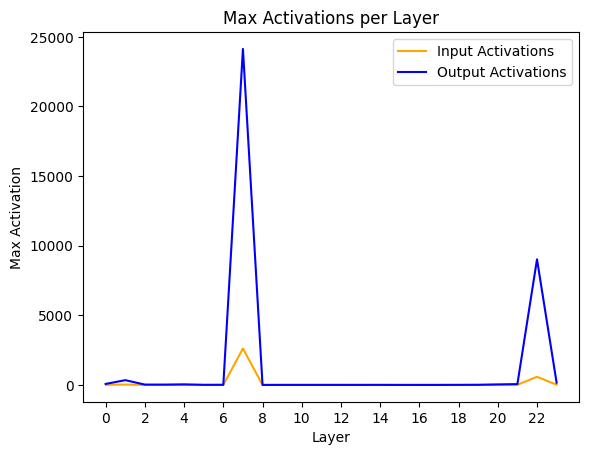

In [10]:
import matplotlib.pyplot as plt

plt.plot(max_input_activations, label="Input Activations", color="orange")
plt.plot(max_output_activations, label="Output Activations", color="blue")
plt.xlabel("Layer")
plt.ylabel("Max Activation")
plt.title("Max Activations per Layer")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see that super activations first appear after layer 1 output So, the super weight must be in layer 1. Lets find it!

Specifically, for a given layer, the channel index of the large maximum-magnitude activation in the down_proj input indicates the row of the super weight.
The channel index of the large maximum-magnitude activation in the down_proj output in the same layer indicates the column of the super weight.

In [11]:
all_outputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[342.2404]]),
indices=tensor([[749]]))

In [12]:
all_inputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[26.4583]]),
indices=tensor([[4987]]))

So the super weight is [749, 4987] of mlp down_proj from layer 1. Lets check that it actually is a super weight by looking at the activations it produces in each layer.

In [13]:
super_activations = [abs(act[0, -1, 749]) for act in all_outputs]


/tmp/ipykernel_2059/3639201231.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


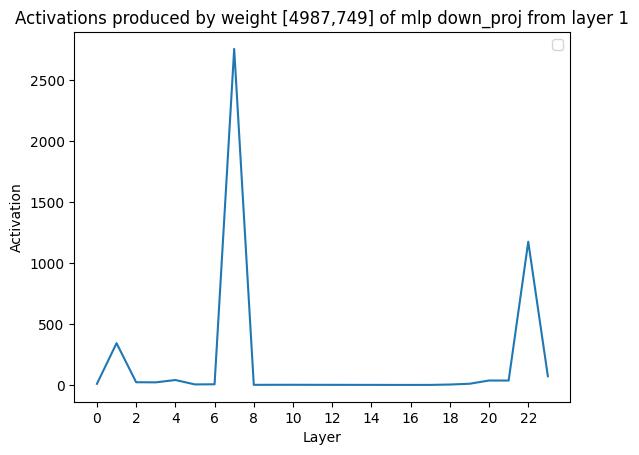

In [14]:
plt.plot(super_activations)
plt.xlabel("Layer")
plt.ylabel("Activation")
plt.title("Activations produced by weight [4987,749] of mlp down_proj from layer 1")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see from that output activations produced by the weight [749, 4987] of mlp down_proj from layer 1 are match to maximum output activations from plot above.

## Calculate perplexity on Wiki-2

In [15]:
inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(f"Initial output: {tokenizer.decode(outputs[0])}")
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model.generate(inputs)
    print(f"Output with weight [4987,749] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Initial output: Transformer architecture is a type of neural network that is used for unsupervised learning. It is a type of neural network that
Output with weight [4987,749] set to 0: Transformer architecture isControlPlane of <jupyter_script>./. . . . . . . . . . . . . . .


In [16]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")[:350] # use subset of data to prevent out of memery error
data = tokenizer("\n\n".join(test["text"]), return_tensors="pt", add_special_tokens=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (27453 > 8192). Running this sequence through the model will result in indexing errors


In [17]:
max_length = 8192
stride = 4086
seq_len = data.input_ids.size(1)
max_length, stride, seq_len



(8192, 4086, 27453)

In [18]:
from tqdm import tqdm
import torch.nn.functional as F

def calculate_perplexity(model, encodings):
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0

    # calculations are based on https://huggingface.co/docs/transformers/en/perplexity#example-calculating-perplexity-with-gpt-2-in--transformers
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop

        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            neg_log_likelihood = outputs.loss # loss is calculated using CrossEntropyLoss which averages over valid labels
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        del input_ids
        if end_loc == seq_len:
            break
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    return ppl.item()


In [19]:
with torch.no_grad():
    ppl=calculate_perplexity(model, data)
    print(f"Initial perplexity: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    ppl = calculate_perplexity(model, data)
    print(f"Perplexity with weight [4987,749] set to 0: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

 71%|███████▏  | 5/7 [00:29<00:11,  5.84s/it]


Initial perplexity: 6.626312255859375


 71%|███████▏  | 5/7 [00:28<00:11,  5.80s/it]

Perplexity with weight [4987,749] set to 0: 8412944.0


In [20]:
del data
del model
torch.cuda.empty_cache()

## Instruct model evaluation

In [21]:
from datasets import load_dataset

dataset = load_dataset("hellaswag", split="validation")
#dataset = load_dataset("hellaswag", split="test")

In [22]:
# code from https://github.com/pchizhov/hellaswag-evaluation/blob/main/evaluation_scripts/evaluate_generation.py
import torch
import json
import re
import datasets
import random


def preprocess(text):
    text = text.strip()
    # NOTE: Brackets are artifacts of the WikiHow dataset portion of HellaSwag.
    text = text.replace(" [title]", ". ")
    text = re.sub("\[.*?\]", "", text)
    text = text.replace("  ", " ")
    return text


def process_docs(dataset: datasets.Dataset, eval_type='full') -> datasets.Dataset:
    def _process_doc(doc):
        if eval_type == 'full':
            ctx = doc["ctx_a"] + " " + doc["ctx_b"].capitalize()
        else:
            ctx = doc["ctx_b"].capitalize()
        choices = [preprocess(ending) for ending in doc["endings"]]
        gold_index = int(doc["label"])

        indices = list(range(len(choices)))
        random.shuffle(indices)
        shuffled_choices = [choices[i] for i in indices]
        new_gold_index = indices.index(gold_index)

        if eval_type == 'full':
            query = preprocess(doc["activity_label"] + ": " + ctx)
        else:
            query = preprocess(ctx)

        out_doc = {
            "query": query,
            "choices": shuffled_choices,
            "gold": new_gold_index,
        }
        return out_doc

    return dataset.map(_process_doc)


def construct_prompt(context, endings):
    prompt = (
        "You are given a situation followed by four possible endings. "
        "Choose the most appropriate ending by selecting the corresponding number. "
        "Respond only with the number of the correct answer.\n\n"
        f"Context: {context}\n"
    )
    for i, ending in enumerate(endings):
        prompt += f"{i +1}. {ending}\n"
    prompt += "\nAnswer: "
    return prompt


def generate_answer(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=inputs.input_ids.shape[1] + 1)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return answer.split("Answer:")[-1].strip().replace(".", "")


def compute_real_accuracy(filename):
    with open(filename, "r") as f:
        data = json.load(f)

    correct = 0
    for question in data:
        digits = [a for a in question['generated_answer'] if a in '1234']
        if len(digits) == 0:
            ## print('ERROR:', question)
            pass
        else:
            correct += int(digits[0] == question['correct_answer'])

    return correct / len(data)

<>:13: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_2059/227691419.py:13: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[.*?\]", "", text)


In [23]:
dataset = process_docs(dataset)



def evaluate(model, total=2500):
    correct = 0
    results = []
    for i in tqdm(range(total)):
        example = dataset[i]
        context = example["query"]
        endings = example["choices"]
        correct_answer = str(example["gold"] + 1)  # Labels are 0-indexed
        prompt = construct_prompt(context, endings)
        generated_answer = generate_answer(model, prompt)
        # print(prompt, generated_answer, correct_answer)

        results.append({
            "context": context,
            "options": endings,
            "correct_answer": correct_answer,
            "generated_answer": generated_answer
        })

        if correct_answer == generated_answer:
            correct += 1

    accuracy = correct / total
    print(f"Initial Accuracy: {accuracy:.2%}")

    filename = f"data/hellaswag_SmalLM2.json"

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)


    real_accuracy = compute_real_accuracy(filename)
    print(f"Real Accuracy: {real_accuracy:.2%}")
    return real_accuracy

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B-Instruct"

device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [25]:
with torch.no_grad():
    print(f"Initial accuracy: {evaluate(model)}")
    super_weight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    print(f"Accuracy with weight [4987,749] set to 0: {evaluate(model)}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value


100%|██████████| 2500/2500 [01:01<00:00, 40.97it/s]


Initial Accuracy: 42.32%
Real Accuracy: 42.32%
Initial accuracy: 0.4232


100%|██████████| 2500/2500 [01:00<00:00, 40.99it/s]

Initial Accuracy: 23.32%
Real Accuracy: 23.32%
Accuracy with weight [4987,749] set to 0: 0.2332


In [26]:
messages = [{"role": "user", "content": "What is the capital of France?"}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
    print(f"Initial output: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
    print(f"Output with weight [749, 4987] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value

Initial output: <|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>
Output with weight [749, 4987] set to 0: <|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_end|>


## Tokens probabilities calculation

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cpu" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [5]:
def get_next_token_probs(model, tokenizer, input_text, target_tokens):
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)
    selcted_prob = []
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids)
            
        # Get the logits for the next token prediction
        next_token_logits = outputs.logits[:, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        
        for i in target_tokens:
            selcted_prob.append(next_token_probs[0, i].item())

    return selcted_prob

In [6]:
import torch
from datasets import load_dataset
from tqdm import tqdm

targets = ['the', 'her', 'J', 'a', '.', 'my', 'A', 'him', 'Sh', 'I', 'M', 'and', 'D', 'his', '"', 'Ch', 'L', 'b', ',', 'T', 'Z', 'Am', 'baby', 'He', 'w', 'Helen', 'but', 'menu', 'portal', 'R', 'you', 'Daniel', 'that', 'Mr', 'cl', 'Ron', 'Mar', 'B', 'Maxim', 's', 'Sam', 'one', 'S', 'H', 'K', 'Charles', 'ma', 'okay', 'Chris', 'V', 'of', 'd', 'N', 'to', 'Cole', 'go', 'me', 'Jen', 'Sarah', 'little', 'first', 'in', 'Gabriel', 'E', 'p', 'Car', 'Co', 'C', 'lo', 'Max', 'Leg', 'your', 'ship', 'Zach', 'kiss', 'po', 'Dragon', 'on', 'Carlos', 'Add', 'bra', 'phone', 'city', 'st', 'letter', 'W', 'h', 'emer', 'vain', 'Leo', 'so', 'Council', 'Bul', 'Josh', 'journal', 'Mare', 'Kate', 'rough', 'dream', 'Vo']
target_tokens = [tokenizer.encode(t, return_tensors="pt").to(device)[0, 0].item()  for t in targets]

N_SAMPLES = 10
dataset = load_dataset("EleutherAI/lambada_openai", "en", split="test")
avg_prob = [0 for _ in range(len(target_tokens))]

for text in tqdm(dataset["text"][:N_SAMPLES]):
    input_text = text
    probabilities = get_next_token_probs(model, tokenizer, input_text, target_tokens)
    
    for i, prob in enumerate(probabilities):
        avg_prob[i] += prob

avg_prob = [p / N_SAMPLES for p in avg_prob]
avg_prob

100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


[6.234285323536426e-08,
 5.568701367530959e-08,
 2.387242846069171e-07,
 2.528732399298406e-06,
 0.4856412133667618,
 9.599532413417933e-08,
 1.8141827431428226e-07,
 1.1961378433393566e-08,
 8.95666509181936e-08,
 2.8523491909737687e-06,
 4.7109375091447526e-07,
 6.511054074564981e-06,
 3.1282047408542903e-07,
 2.2185896436655028e-08,
 0.00012124573029588248,
 4.4211500571655904e-08,
 2.0304792744951782e-07,
 1.1447203627223956e-06,
 0.10699370466172695,
 1.850400817682285e-07,
 7.031828018200237e-08,
 3.5999077424575534e-08,
 1.0844861695891162e-07,
 1.4520172511023333e-07,
 6.380476352596532e-07,
 9.256307302585309e-09,
 1.4110326298499843e-07,
 3.181633876584572e-09,
 1.7169955635054634e-08,
 2.942051935406198e-07,
 1.305384494942885e-07,
 1.0582616648095733e-08,
 3.3284590161830606e-08,
 1.2901044633972791e-08,
 1.2236123734243875e-07,
 2.942051935406198e-07,
 2.2607774307487062e-08,
 2.6925390870791154e-07,
 1.616365521948937e-08,
 1.490327071085318e-07,
 1.7225763467021428e-08,


In [7]:
super_weight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0

avg_prob_droped = [0 for _ in range(len(target_tokens))]
for text in tqdm(dataset["text"][:N_SAMPLES]):
    input_text = text
    probabilities = get_next_token_probs(model, tokenizer, input_text, target_tokens)
    
    for i, prob in enumerate(probabilities):
        avg_prob_droped[i] += prob

avg_prob_droped = [p / N_SAMPLES for p in avg_prob_droped]
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value
avg_prob_droped

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


[1.1041083189411438e-05,
 5.260427874631546e-06,
 1.87844868406728e-06,
 5.6669038667678254e-05,
 0.1925429409602657,
 2.73752756356771e-06,
 7.799556829013455e-06,
 3.9181536266585936e-07,
 1.5631225451784303e-06,
 3.249277972372511e-05,
 6.340731488307938e-06,
 1.2576158280808158e-05,
 6.160115924558341e-06,
 7.500706439955707e-07,
 0.0003476886230870946,
 7.402686492241628e-07,
 3.350149194147889e-06,
 3.10398518195143e-05,
 0.24204370863735675,
 7.264663713613117e-06,
 7.603371720676933e-07,
 6.974970284012727e-07,
 1.124118194439916e-06,
 2.0179331329472917e-06,
 2.3234177297126736e-05,
 5.306497044221814e-07,
 1.1674273406470092e-05,
 2.1832575617386495e-07,
 8.520596665562153e-07,
 5.37356636414188e-06,
 2.6440366843871745e-05,
 1.2006355530891356e-07,
 5.059130040763194e-06,
 1.0450112792881328e-07,
 4.19773800075518e-06,
 5.37356636414188e-06,
 7.698006733392049e-07,
 4.355638395736605e-06,
 3.8792485712590974e-07,
 4.11510985543373e-05,
 2.8599073571555777e-07,
 2.22684529660

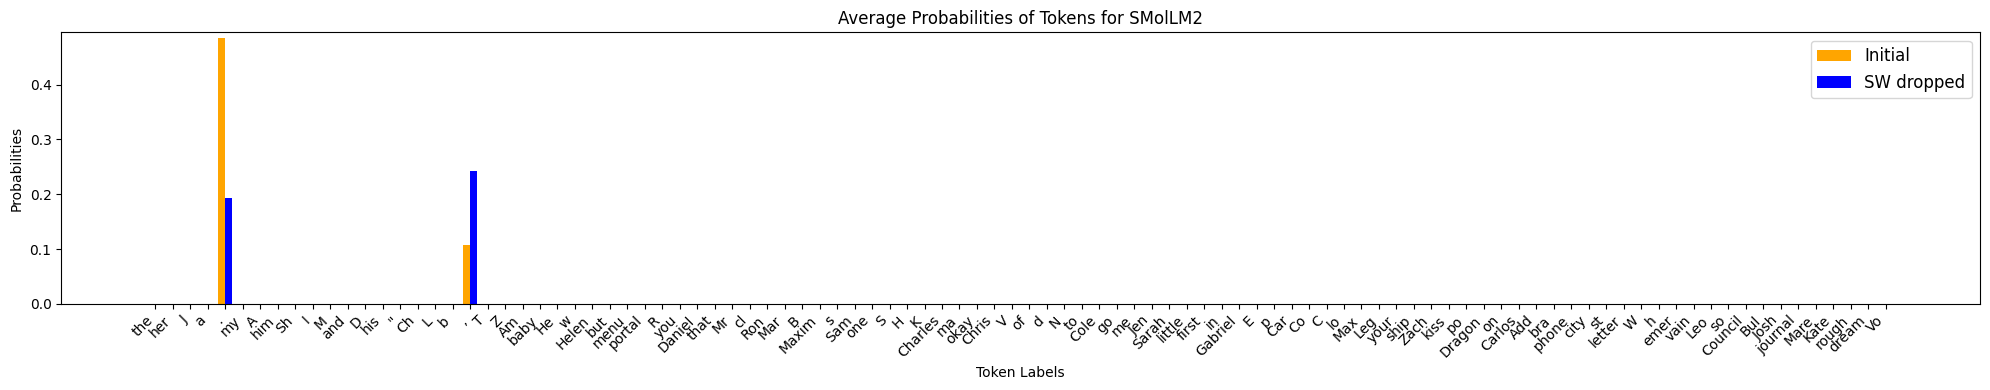

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
plt.xticks(rotation=45, ha="right")

width = 0.4  # Width of the bars
x = range(len(targets))  # X locations for the groups
bars1 = ax.bar([i - width/2 for i in x], avg_prob, width, label="Initial", color='orange', zorder=2)
bars2 = ax.bar([i + width/2 for i in x], avg_prob_droped, width, label="SW dropped", color='blue', zorder=2)
ax.set_xlabel('Token Labels')
ax.set_ylabel('Probabilities')
ax.set_title("Average Probabilities of Tokens for SMolLM2")
ax.set_xticks(x)
ax.set_xticklabels(targets)
ax.legend(prop={"size": 12})

    
# add top padding so enough room to show arrow
ax.set_ylim(0, max(max(avg_prob), max(avg_prob_droped)) + 0.01)  # Add 0.1 or another value for padding

plt.tight_layout()